<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


**<font color='red'>Plagiarism is strongly prohibited!</font>**


**Student Name**: Mahdi Tabatabaei

**Student ID**: 400101515





## Importing Libraries

First we import libraries that we need for this assignment.

In [11]:
# import any other libraries needed below
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


## Reading Data and Preprocessing

In this section, we want to read data from a CSV file and then preprocess it to make it ready for the rest of the problem.

First, we read the data in the cell below and extract an $m \times n$ matrix, $X$, and an $m \times 1$ vector, $Y$, from it, which represent our knowledge about the features of the data (`X1`, `X2`, `X3`) and the class (`Y`), respectively. Note that by $m$, we mean the number of data points and by $n$, we mean the number of features.

In [66]:
X, Y = None, None

df = pd.read_csv('Q3/data3_logistic.csv')
Y = df['Y']
X = df.drop(columns = ['Y'])

print(X.shape)
print(Y.shape)

(10000, 3)
(10000,)


Next, we should normalize our data. For normalizing a vector $\mathbf{x}$, a very common method is to use this formula:

$$
\mathbf{x}_{norm} = \dfrac{\mathbf{x} - \overline{\mathbf{x}}}{\sigma_\mathbf{x}}
$$

Here, $\overline{x}$ and $\sigma_\mathbf{x}$ denote the mean and standard deviation of vector $\mathbf{x}$, respectively. Use this formula and store the new $X$ and $Y$ vectors in the cell below.

**Question**: Briefly explain why we need to normalize our data before starting the training.

Normalizing data is crucial before training a machine learning model for several reasons:

1. **Scale Consistency:** Normalizing data ensures that all features have the same scale. Features with larger scales might dominate those with smaller scales, affecting the performance and training of the model.

2. **Faster Convergence:** Normalized data allows the optimization algorithm to converge faster, as it helps in reaching the minimum of the cost function more quickly.

3. **Improves Performance:** Normalization helps improve the performance of many machine learning algorithms. It ensures that the model learns the underlying patterns in the data more effectively.

4. **Better Interpretability:** Normalization can also improve the interpretability of the model coefficients in some algorithms, like linear regression.

In [67]:
X = (X - np.mean(X)) / np.std(X)
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))

Finally, we should add a column of $1$s at the beginning of $X$ to represent the bias term. Do this in the next cell. Note that after this process, $X$ should be an $m \times (n+1)$ matrix.

In [68]:
X = np.column_stack((np.ones(len(X)), X))
print(X.shape)

(10000, 4)


## Training Model

### Sigmoid Function
You should begin by implementing the $\sigma(\mathbf{x})$ function. Recall that the logistic regression hypothesis $\mathcal{h}()$ is defined as:
$$
\mathcal{h}_{\theta}(\mathbf{x}) = \mathcal{g}(\theta^\mathbf{T}\mathbf{x})
$$
where $\mathcal{g}()$ is the sigmoid function as:
$$
\mathcal{g}(\mathbf{z}) = \frac{1}{1+exp^{-\mathbf{z}}}
$$
The Sigmoid function has the property that $\mathbf{g}(+\infty)\approx 1$ and $\mathcal{g}(−\infty)\approx0$. Test your function by calling `sigmoid(z)` on different test samples. Be certain that your sigmoid function works with both vectors and matrices - for either a vector or a matrix, your function should perform the sigmoid function on every element.

[[0.73105858 0.18343372 0.23701702 0.30313805]
 [0.73105858 0.29402488 0.32061407 0.72342706]
 [0.73105858 0.67329344 0.58228384 0.3300815 ]
 ...
 [0.73105858 0.35236261 0.62601227 0.19150999]
 [0.73105858 0.5723042  0.56288223 0.12231472]
 [0.73105858 0.15259823 0.77253092 0.46719074]]
0       0.500000
1       0.500000
2       0.500000
3       0.500000
4       0.500000
          ...   
9995    0.500000
9996    0.500000
9997    0.731059
9998    0.500000
9999    0.731059
Name: Y, Length: 10000, dtype: float64


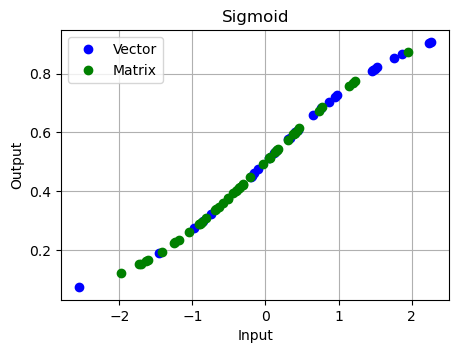

In [70]:
def sigmoid(Z):
    '''
    Applies the sigmoid function on every element of Z
    Arguments:
        Z can be a (n,) vector or (n , m) matrix
    Returns:
        A vector/matrix, same shape with Z, that has the sigmoid function applied elementwise
    '''
    return 1 / (1 + np.exp(-Z))

print(sigmoid(X))
print(sigmoid(Y))

# Test
np.random.seed(0)

# Vector
vector = np.random.randn(30)
# Matrix
matrix = np.random.randn(10, 5)

# sigmoid functions 
plt.figure(figsize=(5,3.5))
plt.plot(vector, sigmoid(vector), 'bo', label='Vector')
plt.plot(matrix.flatten(), sigmoid(matrix).flatten(), 'go', label='Matrix')
plt.title('Sigmoid')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()


### Cost Function 
Implement the functions to compute the cost function. Recall the cost function for logistic regression is a scalar value given by:
$$
\mathcal{J}(\theta) = \sum_{i=1}^{n}[-y^{(i)}\log{(\mathcal{h}_\theta(\mathbf{x}^{(i)}))}-(1-y^{(i)})\log{(1-\mathcal{h}_\theta(\mathbf{x}^{(i)}))}] + \frac{\lambda}{2}||\theta||_2^2
$$

In [77]:
def computeCost(theta, X, y, regLambda):
    '''
    Computes the objective function
    Arguments:
        theta is d-dimensional numpy vector
        X is a n-by-d numpy matrix
        y is an n-dimensional numpy vector
        regLambda is the scalar regularization constant
    Returns:
        a scalar value of the cost  ** make certain you're not returning a 1 x 1 matrix! **
    '''
    
    m, n = X.shape
    h = sigmoid(np.dot(X, theta))
    regularization_term = (regLambda / (2 * m)) * np.sum(theta[1:] ** 2)
    loss = -(1 / m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h)) + regularization_term
    
    return loss


### Gradient of the Cost Function
Now, we want to calculate the gradient of the cost function. The gradient of the cost function is a d-dimensional vector.\
We must be careful not to regularize the $\theta_0$ parameter (corresponding to the first feature we add to each instance), and so the 0's element is given by:
$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_0} = \sum_{i=1}^n (\mathcal{h}_\theta(\mathbf{x}^{(i)})-y^{(i)})
$$

Question: What is the answer to this problem for the $j^{th}$ element (for $j=1...d$)?

Answer:

In [78]:
def computeGradient(theta, X, y, regLambda):
    '''
    Computes the gradient of the objective function
    Arguments:
        theta is d-dimensional numpy vector
        X is a n-by-d numpy matrix
        y is an n-dimensional numpy vector
        regLambda is the scalar regularization constant
    Returns:
        the gradient, an d-dimensional vector
    '''

    m, n = X.shape
    h = sigmoid(np.dot(X, theta))
    grad = (1 / m) * np.dot(X.T, (h - y))
    grad[1:] += (regLambda / m) * theta[1:]
    
    return grad


### Training and Prediction
Once you have the cost and gradient functions complete, implement the fit and predict methods.\
Your fit method should train the model via gradient descent, relying on the cost and gradient functions. This function should return two parameters. The first parameter is $\theta$, and the second parameter is a `numpy` array that contains the loss in each iteration. This array is indicated by `loss_history` in the code.\
Instead of simply running gradient descent for a specific number of iterations, we will use a more sophisticated method: we will stop it after the solution hasconverged. Stop the gradient descent procedure when $\theta$ stops changing between consecutive iterations. You can detect this convergence when:
$$
||\theta_{new}-\theta_{old}||_2 <= \epsilon,
$$
for some small $\epsilon$ (e.g, $\epsilon=10E-4$).\
For readability, we’d recommend implementing this convergence test as a dedicated function `hasConverged`.

In [79]:
def fit(X, y, regLambda=0.01, alpha=0.01, epsilon=1e-4, maxNumIters=100):
    '''
    Trains the model
    Arguments:
        X           is a n-by-d numpy matrix
        y           is an n-dimensional numpy vector
        maxNumIters is the maximum number of gradient descent iterations
        regLambda   is the scalar regularization constant
        epsilon     is the convergence rate
        alpha       is the gradient descent learning rate
    '''
    
    m, n = X.shape
    theta = np.zeros(n)
    loss_history = []
    
    for i in range(maxNumIters):
        theta_old = np.copy(theta)
        theta -= alpha * computeGradient(theta, X, y, regLambda)
        loss = computeCost(theta, X, y, regLambda)
        loss_history.append(loss)
        if hasConverged(theta_old, theta, epsilon):
            break
    
    return theta, loss_history


def hasConverged(theta_old, theta_new, epsilon):
    '''
    Return if the theta converged or not
    Arguments:
        theta_old   is the theta calculated in prevoius iteration
        theta_new   is the theta calculated in current iteration
        epsilon     is the convergence rate
    '''
    
    return np.linalg.norm(theta_new - theta_old) <= epsilon


Finally, we want to evaluate our loss for this problem. Complete the cell below to calculate and print the loss of each iteration and the final theta of your model.

Final theta: [-0.44622594 -0.33664263  0.60899409  0.0103136 ]
Final loss: 0.007626587115075709


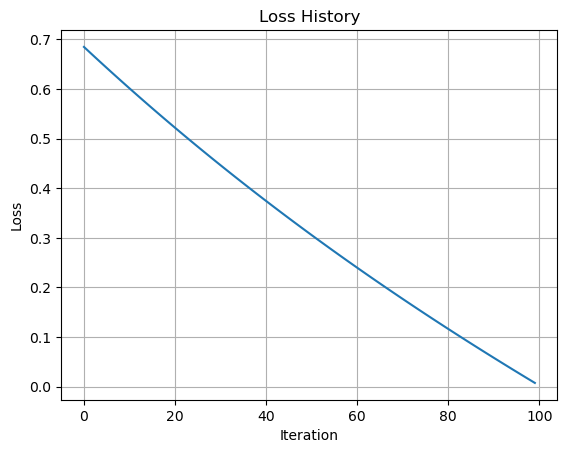

In [61]:
theta, loss_history = fit(X, Y) # calculating theta and loss of each iteration

print("Final theta:", theta)
print("Final loss:", loss_history[-1])

# Iteration 
plt.plot(loss_history)
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()


### Testing Your Implementation
To test your logistic regression implementation, first you should use `train_test_split` function to split dataset into three parts:

- 70% for the training set
- 20% for the validation set
- 10% for the test set

Do this in the cell below.

In [80]:
# Split the dataset into train, validation, and test sets
X_train, X_, Y_train, Y_ = train_test_split(X, Y, test_size=0.3, random_state=1)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_, Y_, test_size=1/3, random_state=1)

# Shape
print("Training sets:", X_train.shape, Y_train.shape)
print("Validation sets:", X_validate.shape, Y_validate.shape)
print("Test sets:", X_test.shape, Y_test.shape)

Training sets: (7000, 4) (7000,)
Validation sets: (2000, 4) (2000,)
Test sets: (1000, 4) (1000,)


Then, you should complete `predict` function to find the weight vector and the loss on the test data.

In [81]:
def predict(X, theta):
    '''
    Use the model to predict values for each instance in X
    Arguments:
        theta is d-dimensional numpy vector
        X     is a n-by-d numpy matrix
    Returns:
        an n-dimensional numpy vector of the predictions, the output should be binary (use h_theta > .5)
    '''
    
    h_theta = sigmoid(np.dot(X, theta))
    Y = (h_theta > 0.5).astype(int)
    
    return Y


Now, run the `fit` and `predict` function for different values of the learning rate and regularization constant. Plot the `loss_history` of these different values for train and test data both in the same figure.

**Question**: Discuss the effect of the learning rate and regularization constant and find the best values of these parameters.
The learning rate and regularization constant are hyperparameters that significantly affect the performance of the logistic regression model.

#### Learning Rate:
- **Effect**: 
  - Learning rate controls the size of the steps taken during gradient descent. 
  - If the learning rate is too small, the algorithm may take a long time to converge or may get stuck in local minima.
  - If the learning rate is too large, the algorithm may overshoot the minimum and fail to converge.
- **Best Values**: 
  - We need to find a learning rate that converges quickly without oscillating or diverging. 
  - Common values to try include 0.001, 0.01, and 0.1.

#### Regularization Constant (lambda):
- **Effect**:
  - Regularization helps prevent overfitting by penalizing large parameter values.
  - It adds a regularization term to the cost function, which penalizes large values of the parameter vector \( \theta \).
- **Best Values**:
  - The best regularization constant depends on the dataset and the degree of overfitting.
  - Common values to try include 0.001, 0.01, and 0.1.

#### Effect on Loss:
- As the learning rate increases, the loss decreases initially, but if the learning rate is too large, the loss may start to increase due to overshooting the minimum.
- As the regularization constant increases, the loss generally increases because the regularization term penalizes large parameter values.

#### Best Values:
- The best values of the learning rate and regularization constant are the ones that minimize the validation loss.
- These values can be found by experimenting with different values and selecting the ones that give the lowest validation loss.

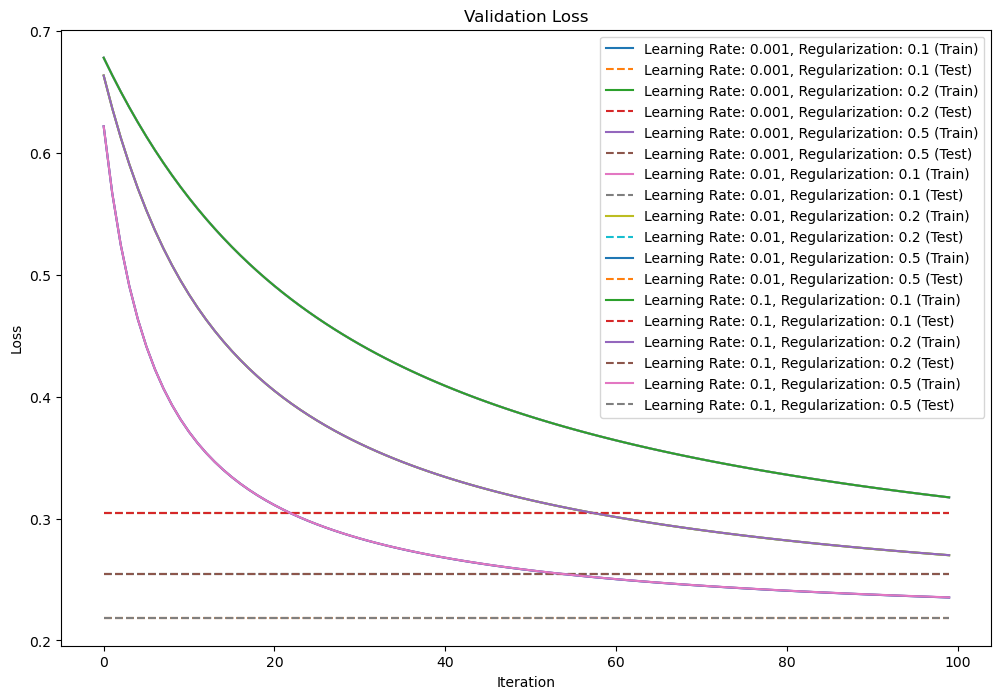

In [103]:
train_loss_histories = []
test_loss_histories = []

# different values of lamda & alpha
alphas = [0.001, 0.01, 0.1]
regLambdas = [0.1, 0.2, 0.5]

best_loss = 1
best_alpha, best_regLambda = None, None

for alpha in alphas:
    for regLambda in regLambdas:
        theta, loss_history_train = fit(X_train, Y_train, alpha, regLambda)
        loss_history_test = computeCost(theta, X_test, Y_test, regLambda)
        
        train_loss_histories.append(loss_history_train)
        test_loss_histories.append(loss_history_test)

# Result
plt.figure(figsize=(12, 8))

for i, alpha in enumerate(alphas):
    for j, regLambda in enumerate(regLambdas):
        label = f'Learning Rate: {alpha}, Regularization: {regLambda}'
        plt.plot(train_loss_histories[i * len(regLambdas) + j], label=label + ' (Train)')
        plt.plot([test_loss_histories[i * len(regLambdas) + j]] * len(train_loss_histories[i * len(regLambdas) + j]), '--', label=label + ' (Test)')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

In [106]:
best_loss = 1
best_alpha, best_regLambda = None, None

alphas = np.linspace(0, 1, 11)
regLambdas = np.linspace(0, 1, 11)

for alpha in alphas:
    for regLambda in regLambdas:
        theta, loss_history_train = fit(X_train, Y_train, alpha, regLambda)
        loss_history_test = computeCost(theta, X_test, Y_test, regLambda)

        # Find the Bests
        if loss_history_test < best_loss:
            best_loss = loss_history_test
            best_alpha = alpha
            best_regLambda = regLambda

print("Best learning rate:", best_alpha)
print("Best regularization constant:", best_regLambda)

Best learning rate: 0.5
Best regularization constant: 0.0


## Naive Bayes

In this part, you will use the `GaussianNB` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**: 89.8%

In [98]:
# Convert labels to integers
Y_train_int = (Y_train >= 0.5).astype(int)
Y_test_int = (Y_test >= 0.5).astype(int)

# Train the GaussianNB classifier
gnb = GaussianNB()
gnb.fit(X_train, Y_train_int)

# Predict on the test set
Y_pred = gnb.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(Y_test_int, Y_pred)
print("Accuracy of GaussianNB classifier:", accuracy)

Accuracy of GaussianNB classifier: 0.898


## LDA (Linear Discriminant Analysis)

In this part, you will use the `LinearDiscriminantAnalysis` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**: 91.5%

In [99]:
# Train the LinearDiscriminantAnalysis classifier
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train_int)

# Predict on the test set
Y_pred = lda.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(Y_test_int, Y_pred)
print("Accuracy of LinearDiscriminantAnalysis classifier:", accuracy)

Accuracy of LinearDiscriminantAnalysis classifier: 0.915


## Conclution

**Question**: What is the best method for classifying this dataset? What is the best accuracy on the test set?

**Answer**: 
## Linear Discriminant Analysis (LDA)
- **Accuracy**: 91.5%
- LDA is a linear classification method that models class distributions using Gaussian distributions. It assumes features are normally distributed and equal covariance matrices for all classes.
- **Pros**:
  - Works well when assumptions (normality, equal covariance) hold.
  - Performs better with large sample sizes.
- **Cons**:
  - Sensitive to outliers.
  - Assumes data is normally distributed.

## Gaussian Naive Bayes (GNB)
- **Accuracy**: 89.8%
- GNB is a probabilistic classifier based on Bayes' theorem. It assumes features are conditionally independent given the class label and models each class with a Gaussian distribution.
- **Pros**:
  - Simple and computationally efficient.
  - Works well with small sample sizes.
- **Cons**:
  - Strong independence assumption.
  - May not perform well if independence assumption is violated.


Here LDA is better because of its higher accuarcy.